# Implementing AV-HuBERT for Automatic Lip-Reading

In this notebook, we use the pre-trained AV-HuBERT model for automatic lip reading on a synthetic dataset created using chosen sentences from movie quotes.
The objective is to evaluate the effectiveness of this model on certain pre-defined variables and to suggest improvements.

## Setting up the environment
This section installs necessary python packages for the other sections. Run it first.

In [ ]:
%cd /content/
!git clone https://github.com/facebookresearch/av_hubert.git

%cd av_hubert
!git submodule init
!git submodule update
!pip install scipy
!pip install sentencepiece
!pip install python_speech_features
!pip install scikit-video

%cd fairseq
!pip install ./

/content
Cloning into 'av_hubert'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 115 (delta 0), reused 1 (delta 0), pack-reused 111
Receiving objects: 100% (115/115), 4.62 MiB | 7.22 MiB/s, done.
Resolving deltas: 100% (46/46), done.
/content/av_hubert
Submodule 'fairseq' (https://github.com/pytorch/fairseq) registered for path 'fairseq'
Cloning into '/content/av_hubert/fairseq'...
Submodule path 'fairseq': checked out 'afc77bdf4bb51453ce76f1572ef2ee6ddcda8eeb'
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 4.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for python-speech-features: filename=python_speech_features-0.6

## Preprocessing videos
This section illustrates how to prepare a video clip.

1. Install necessary tools for preprocessing

In [ ]:
!mkdir -p /content/data/misc/
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 -O /content/data/misc/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d /content/data/misc/shape_predictor_68_face_landmarks.dat.bz2
!wget --content-disposition https://github.com/mpc001/Lipreading_using_Temporal_Convolutional_Networks/raw/master/preprocessing/20words_mean_face.npy -O /content/data/misc/20words_mean_face.npy

--2022-12-12 16:31:52--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘/content/data/misc/shape_predictor_68_face_landmarks.dat.bz2’

/content/data/misc/ 100%[===================>]  61.07M  15.3MB/s    in 5.9s    

2022-12-12 16:31:58 (10.3 MB/s) - ‘/content/data/misc/shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]

--2022-12-12 16:32:20--  https://github.com/mpc001/Lipreading_using_Temporal_Convolutional_Networks/raw/master/preprocessing/20words_mean_face.npy
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mpc001/Lipreading_using_Temporal_Convolutional_Networks/master/preprocessing/20words_

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!ls

Mounted at /content/drive
CODE_OF_CONDUCT.md  examples	 hubconf.py	 README.md  tests
CONTRIBUTING.md     fairseq	 LICENSE	 scripts    train.py
docs		    fairseq_cli  pyproject.toml  setup.py


In [ ]:
!ls /content/drive/MyDrive/FinalProjectDL/code/videos/

David  Keaton  sentence1   sentence2  sentence4  sentence6  sentence8  Vidya
Joe    Kim     sentence10  sentence3  sentence5  sentence7  sentence9


In [ ]:
# !cp /content/data/8_2.mp4 /content/data/clip.mp4

3. Extract mouth ROI.

In [ ]:
%cd /content/av_hubert/avhubert/

import dlib, cv2, os
import numpy as np
import skvideo
import skvideo.io
from tqdm import tqdm
from preparation.align_mouth import landmarks_interpolate, crop_patch, write_video_ffmpeg
from IPython.display import HTML
from base64 import b64encode

def play_video(video_path, width=200):
  mp4 = open(video_path,'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML(f"""
  <video width={width} controls>
        <source src="{data_url}" type="video/mp4">
  </video>
  """)

def detect_landmark(image, detector, predictor):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    rects = detector(gray, 1)
    coords = None
    for (_, rect) in enumerate(rects):
        shape = predictor(gray, rect)
        coords = np.zeros((68, 2), dtype=np.int32)
        for i in range(0, 68):
            coords[i] = (shape.part(i).x, shape.part(i).y)
    return coords

def preprocess_video(input_video_path, output_video_path, face_predictor_path, mean_face_path):
  detector = dlib.get_frontal_face_detector()
  predictor = dlib.shape_predictor(face_predictor_path)
  STD_SIZE = (256, 256)
  mean_face_landmarks = np.load(mean_face_path)
  stablePntsIDs = [33, 36, 39, 42, 45]
  videogen = skvideo.io.vread(input_video_path)
  frames = np.array([frame for frame in videogen])
  landmarks = []
  for frame in tqdm(frames):
      landmark = detect_landmark(frame, detector, predictor)
      landmarks.append(landmark)
  preprocessed_landmarks = landmarks_interpolate(landmarks)
  rois = crop_patch(input_video_path, preprocessed_landmarks, mean_face_landmarks, stablePntsIDs, STD_SIZE,
                        window_margin=12, start_idx=48, stop_idx=68, crop_height=96, crop_width=96)
  write_video_ffmpeg(rois, output_video_path, "/usr/bin/ffmpeg")
  return

/content/av_hubert/avhubert


In [ ]:
# play_video('/content/data/clip.mp4', width=300)

In [ ]:
# face_predictor_path = "/content/data/misc/shape_predictor_68_face_landmarks.dat"
# mean_face_path = "/content/data/misc/20words_mean_face.npy"
# origin_clip_path = "/content/data/clip.mp4"
# mouth_roi_path = "/content/data/roi.mp4"
# preprocess_video(origin_clip_path, mouth_roi_path, face_predictor_path, mean_face_path)
# play_video(mouth_roi_path)

## Import a pre-trained model
This section illustrates how to load a pre-trained model and use it for inference.

1. Download a model checkpoint

In [ ]:
!pwd
%mkdir -p /content/data/
!wget https://dl.fbaipublicfiles.com/avhubert/model/lrs3_vox/vsr/base_vox_433h.pt -O /content/data/finetune-model.pt

/content/av_hubert/avhubert
--2022-12-12 16:32:51--  https://dl.fbaipublicfiles.com/avhubert/model/lrs3_vox/vsr/base_vox_433h.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1928063847 (1.8G) [binary/octet-stream]
Saving to: ‘/content/data/finetune-model.pt’

/content/data/finet 100%[===================>]   1.79G  22.3MB/s    in 90s     

2022-12-12 16:34:22 (20.4 MB/s) - ‘/content/data/finetune-model.pt’ saved [1928063847/1928063847]



2. Inference with the model

In [ ]:
%cd /content/av_hubert/avhubert
import cv2
import tempfile
from argparse import Namespace
import fairseq
from fairseq import checkpoint_utils, options, tasks, utils
from fairseq.dataclass.configs import GenerationConfig
from IPython.display import HTML

def predict(video_path, ckpt_path, user_dir):
  num_frames = int(cv2.VideoCapture(video_path).get(cv2.CAP_PROP_FRAME_COUNT))
  data_dir = tempfile.mkdtemp()
  tsv_cont = ["/\n", f"test-0\t{video_path}\t{None}\t{num_frames}\t{int(16_000*num_frames/25)}\n"]
  label_cont = ["DUMMY\n"]
  with open(f"{data_dir}/test.tsv", "w") as fo:
    fo.write("".join(tsv_cont))
  with open(f"{data_dir}/test.wrd", "w") as fo:
    fo.write("".join(label_cont))
  utils.import_user_module(Namespace(user_dir=user_dir))
  modalities = ["video"]
  gen_subset = "test"
  gen_cfg = GenerationConfig(beam=20)
  models, saved_cfg, task = checkpoint_utils.load_model_ensemble_and_task([ckpt_path])
  models = [model.eval().cuda() for model in models]
  models = [model.eval() for model in models]
  saved_cfg.task.modalities = modalities
  saved_cfg.task.data = data_dir
  saved_cfg.task.label_dir = data_dir
  task = tasks.setup_task(saved_cfg.task)
  task.load_dataset(gen_subset, task_cfg=saved_cfg.task)
  generator = task.build_generator(models, gen_cfg)

  def decode_fn(x):
      dictionary = task.target_dictionary
      symbols_ignore = generator.symbols_to_strip_from_output
      symbols_ignore.add(dictionary.pad())
      return task.datasets[gen_subset].label_processors[0].decode(x, symbols_ignore)

  itr = task.get_batch_iterator(dataset=task.dataset(gen_subset)).next_epoch_itr(shuffle=False)
  sample = next(itr)
  sample = utils.move_to_cuda(sample)
  hypos = task.inference_step(generator, models, sample)
  ref = decode_fn(sample['target'][0].int().cpu())
  hypo = hypos[0][0]['tokens'].int().cpu()
  hypo = decode_fn(hypo)
  return hypo


# HTML(f"""
#   <h3>
#     Prediction - {hypo}
#   </h3>
#   """)

/content/av_hubert/avhubert


/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


3. Extract visual feature with the model

In [ ]:
%cd /content/av_hubert/avhubert
import cv2
import tempfile
import torch
import utils as avhubert_utils
from argparse import Namespace
import fairseq
from fairseq import checkpoint_utils, options, tasks, utils
from IPython.display import HTML

def extract_visual_feature(video_path, ckpt_path, user_dir, is_finetune_ckpt=False):
  utils.import_user_module(Namespace(user_dir=user_dir))
  models, saved_cfg, task = checkpoint_utils.load_model_ensemble_and_task([ckpt_path])
  transform = avhubert_utils.Compose([
      avhubert_utils.Normalize(0.0, 255.0),
      avhubert_utils.CenterCrop((task.cfg.image_crop_size, task.cfg.image_crop_size)),
      avhubert_utils.Normalize(task.cfg.image_mean, task.cfg.image_std)])
  frames = avhubert_utils.load_video(video_path)
  print(f"Load video {video_path}: shape {frames.shape}")
  frames = transform(frames)
  print(f"Center crop video to: {frames.shape}")
  frames = torch.FloatTensor(frames).unsqueeze(dim=0).unsqueeze(dim=0).cuda()
  model = models[0]
  if hasattr(models[0], 'decoder'):
    print(f"Checkpoint: fine-tuned")
    model = models[0].encoder.w2v_model
  else:
    print(f"Checkpoint: pre-trained w/o fine-tuning")
  model.cuda()
  model.eval()
  with torch.no_grad():
    # Specify output_layer if you want to extract feature of an intermediate layer
    feature, _ = model.extract_finetune(source={'video': frames, 'audio': None}, padding_mask=None, output_layer=None)
    feature = feature.squeeze(dim=0)
  print(f"Video feature shape: {feature.shape}")
  return feature



/content/av_hubert/avhubert


In [ ]:
video_dir = '/content/drive/MyDrive/FinalProjectDL/code/videos/Keaton/'

In [ ]:
# Import the necessary modules
import os
from fnmatch import fnmatch

# Define the pattern to match
pattern = "*.mp4"

# Use the `!` operator to run a shell command to get a list of files
# in the current directory
files = !ls -1 $video_dir

# Filter the list of files to only include those with the ".mp4" extension
mp4_files = [file.replace('\'','') for file in files ]

# Print the list of files
print( mp4_files, len(mp4_files))



['10_1_3.mp4', '10_2_3.mp4', '1_1_3.mp4', '1_2_3.mp4', '2_1_3.mp4', '2_2_3.mp4', '3_1_3.mp4', '3_2_3.mp4', '4_1_3.mp4', '4_2_3.mp4', '5_1_3.mp4', '5_2_3.mp4', '6_1_3.mp4', '6_2_3.mp4', '7_1_3.mp4', '7_2_3.mp4', '8_1_3.mp4', '8_2_3.mp4', '9_1_3.mp4', '9_2_3.mp4'] 20


In [ ]:
outArray = []
for num in range(len(mp4_files)):
  face_predictor_path = "/content/data/misc/shape_predictor_68_face_landmarks.dat"
  mean_face_path = "/content/data/misc/20words_mean_face.npy"
  origin_clip_path = video_dir + '/' + mp4_files[num]
  mouth_roi_path = "/content/data/roi.mp4"
  preprocess_video(origin_clip_path, mouth_roi_path, face_predictor_path, mean_face_path)
  mouth_roi_path, ckpt_path = "/content/data/roi.mp4", "/content/data/finetune-model.pt"
  user_dir = "/content/av_hubert/avhubert"
  hypo = predict(mouth_roi_path, ckpt_path, user_dir)
  outArray.append((num, hypo))

100%|██████████| 121/121 [02:03<00:00,  1.02s/it]


In [ ]:
outArray

[(0, 'alright'),
 (1, 'no trying not to do not there is no child'),
 (2, 'other jobs can come true if we have the urge to pursue them'),
 (3, 'and if our dreams can come true if we have the courage to pursue them'),
 (4,
  "it's intuitive to measure our own family using our gifts for the paramedic of others to let them"),
 (5,
  'and i see you in the magical fabric you see a gift for the power of the light or surround them'),
 (6, "we think they're cheaping they're going to refer"),
 (7, 'we think the brain patterns were cut it was fun'),
 (8, "just because something worse doesn't mean it can't be improved"),
 (9, "just because something works doesn't matter can't be improved"),
 (10,
  'i mean you have mistakes and all the time everything seems to work out'),
 (11, 'and many creative mistakes all the time everything seems to work out'),
 (12,
  "we don't want to fill the maps up to burning structure and hates and every months as well"),
 (13,
  'when you left your maps in your body ch

## WER score calculation
This section illustrates how to calculate the WER score between the original and the predicted sentences using the  Levenshtein distance algorithm.

Source: https://pyzone.dev/word-error-rate-in-python/

In [ ]:
def wer(ref, hyp ,debug=True):
    r = ref.split()
    h = hyp.split()
    #costs will holds the costs, like in the Levenshtein distance algorithm
    costs = [[0 for inner in range(len(h)+1)] for outer in range(len(r)+1)]
    # backtrace will hold the operations we've done.
    # so we could later backtrace, like the WER algorithm requires us to.
    backtrace = [[0 for inner in range(len(h)+1)] for outer in range(len(r)+1)]

    OP_OK = 0
    OP_SUB = 1
    OP_INS = 2
    OP_DEL = 3
    DEL_PENALTY = 1
    INS_PENALTY = 1
    SUB_PENALTY = 1

    # First column represents the case where we achieve zero
    # hypothesis words by deleting all reference words.
    for i in range(1, len(r)+1):
        costs[i][0] = DEL_PENALTY*i
        backtrace[i][0] = OP_DEL

    # First row represents the case where we achieve the hypothesis
    # by inserting all hypothesis words into a zero-length reference.
    for j in range(1, len(h) + 1):
        costs[0][j] = INS_PENALTY * j
        backtrace[0][j] = OP_INS

    # computation
    for i in range(1, len(r)+1):
        for j in range(1, len(h)+1):
            if r[i-1] == h[j-1]:
                costs[i][j] = costs[i-1][j-1]
                backtrace[i][j] = OP_OK
            else:
                substitutionCost = costs[i-1][j-1] + SUB_PENALTY # penalty is always 1
                insertionCost    = costs[i][j-1] + INS_PENALTY   # penalty is always 1
                deletionCost     = costs[i-1][j] + DEL_PENALTY   # penalty is always 1

                costs[i][j] = min(substitutionCost, insertionCost, deletionCost)
                if costs[i][j] == substitutionCost:
                    backtrace[i][j] = OP_SUB
                elif costs[i][j] == insertionCost:
                    backtrace[i][j] = OP_INS
                else:
                    backtrace[i][j] = OP_DEL

    # back trace though the best route:
    i = len(r)
    j = len(h)
    numSub = 0
    numDel = 0
    numIns = 0
    numCor = 0
    if debug:
        print("OP\tREF\tHYP")
        lines = []
    while i > 0 or j > 0:
        if backtrace[i][j] == OP_OK:
            numCor += 1
            i-=1
            j-=1
            if debug:
                lines.append("OK\t" + r[i]+"\t"+h[j])
        elif backtrace[i][j] == OP_SUB:
            numSub +=1
            i-=1
            j-=1
            if debug:
                lines.append("SUB\t" + r[i]+"\t"+h[j])
        elif backtrace[i][j] == OP_INS:
            numIns += 1
            j-=1
            if debug:
                lines.append("INS\t" + "****" + "\t" + h[j])
        elif backtrace[i][j] == OP_DEL:
            numDel += 1
            i-=1
            if debug:
                lines.append("DEL\t" + r[i]+"\t"+"****")
    if debug:
        lines = reversed(lines)
        for line in lines:
            print(line)
        print("#cor " + str(numCor))
        print("#sub " + str(numSub))
        print("#del " + str(numDel))
        print("#ins " + str(numIns))
    # return (numSub + numDel + numIns) / (float) (len(r))
    wer_result = round( (numSub + numDel + numIns) / (float) (len(r)), 3)
    return {'WER':wer_result, 'numCor':numCor, 'numSub':numSub, 'numIns':numIns, 'numDel':numDel, "numCount": len(r)}


In [ ]:
sample_original = ['All our dreams can come true if we have the courage to pursue them',
            'Its the duty of the Madrigal family to use their gifts for the betterment of others around them',
            'Without the Black Panther Wakanda will fall',
            'Just because something works doesn’t mean it can’t be improved',
            'I make grave mistakes all the time Everything seems to work out',
            'We Do Not Follow Maps To Buried Treasure And X Never Ever Marks The Spot',
            'Okay here we go Focus speed I am speed One winner 42 losers I eat losers for breakfast',
            'With great power comes great responsibility',
            'Named must be your fear before banish it you can',
            'No Try not Do Or do not There is no try']

In [ ]:
filename_with_metadata = []
for file in mp4_files:
  sentenceid, angleid, personid = file.replace('\'','').replace('.mp4','').split('_')
  filename_with_metadata.append((file, int(sentenceid),int(angleid),int(personid)))
filename_with_metadata

[('10_1_3.mp4', 10, 1, 3),
 ('10_2_3.mp4', 10, 2, 3),
 ('1_1_3.mp4', 1, 1, 3),
 ('1_2_3.mp4', 1, 2, 3),
 ('2_1_3.mp4', 2, 1, 3),
 ('2_2_3.mp4', 2, 2, 3),
 ('3_1_3.mp4', 3, 1, 3),
 ('3_2_3.mp4', 3, 2, 3),
 ('4_1_3.mp4', 4, 1, 3),
 ('4_2_3.mp4', 4, 2, 3),
 ('5_1_3.mp4', 5, 1, 3),
 ('5_2_3.mp4', 5, 2, 3),
 ('6_1_3.mp4', 6, 1, 3),
 ('6_2_3.mp4', 6, 2, 3),
 ('7_1_3.mp4', 7, 1, 3),
 ('7_2_3.mp4', 7, 2, 3),
 ('8_1_3.mp4', 8, 1, 3),
 ('8_2_3.mp4', 8, 2, 3),
 ('9_1_3.mp4', 9, 1, 3),
 ('9_2_3.mp4', 9, 2, 3)]

In [ ]:
sample_outArray = [(0, 'all our dreams can come to if we have the courage to pursue them'),
 (1, 'all our dreams can come to if we have the courage to be to them'),
 (2, 'all of our dreams can come true we have to learn to pursue them'),
 (3, 'all of our dreams can come true if we have the courage to pursue them'),
 (4, 'and if our dreams can come true if we have the urge to pursue them'),
 (5, 'other times can come true if we have the urge to pursue them')]

In [ ]:
wer_scores = []
for x in range(len(outArray)):
  wer_score = wer(sample_original[filename_with_metadata[x][1]-1].lower(), outArray[x][1])
  # print(filename_with_metadata[x])
  # print(sample_outArray[x][1])
  wer_scores.append((filename_with_metadata[x][1], filename_with_metadata[x][2],
                     filename_with_metadata[x][3], wer_score['WER']))

In [ ]:
wer_scores

## Model Evaluation
In this section we use the following pre-defined variables to evaluate the model performance:
* Gender of the person speaking
* Native vs non-native speakers
* Angle at the video was taken
* Sentences with jumbled grammar or too many breaks and pauses
* Sentences with newer context than when the model was originally trained

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
training_data = pd.read_excel('/content/drive/MyDrive/FinalProjectDL/code/Model_Evaluation.xlsx')

In [ ]:
training_data

,Name,Sentence,Prediction,WER_score,Native_speaker,Woman,Head_on,New_context,Bad_Grammar
0,Vidya,All our dreams can come true if we have the co...,all our dreams can come to you if we have the ...,0.071,0.0,1.0,1.0,0.0,0.0
1,Vidya,All our dreams can come true if we have the co...,all our dreams can come to if we have the cour...,0.214,0.0,1.0,0.0,0.0,0.0
2,Vidya,It's the duty of the Madrigal family to use th...,it is the beauty and family includes their gif...,0.368,0.0,1.0,1.0,1.0,0.0
3,Vidya,It's the duty of the Madrigal family to use th...,it is the duty of the paradigm family to use t...,0.105,0.0,1.0,0.0,1.0,0.0
4,Vidya,Without the Black Panther Wakanda will fall,without the black panth what are you will fall,0.571,0.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
95,Keaton,With great power comes great responsibility,with the great power helps to get the responsi...,0.833,1.0,0.0,0.0,0.0,0.0
96,Keaton,Named must be your fear before banish it you can,name you must be your fear before punishing yo...,0.400,1.0,0.0,1.0,0.0,1.0
97,Keaton,Named must be your fear before banish it you can,named must be your fear performed energy today,0.500,1.0,0.0,0.0,0.0,1.0
98,Keaton,No Try not Do Or do not There is no try,alright,1.000,1.0,0.0,1.0,0.0,1.0


In [ ]:
training_data.columns

Index(['Name', 'Sentence', 'Prediction', 'WER_score', 'Native_speaker',
       'Woman', 'Head_on', 'New_context', 'Bad_Grammar'],
      dtype='object')

In [ ]:
training_data.fillna(0)

,Name,Sentence,Prediction,WER_score,Native_speaker,Woman,Head_on,New_context,Bad_Grammar
0,Vidya,All our dreams can come true if we have the co...,all our dreams can come to you if we have the ...,0.071,0.0,1.0,1.0,0.0,0.0
1,Vidya,All our dreams can come true if we have the co...,all our dreams can come to if we have the cour...,0.214,0.0,1.0,0.0,0.0,0.0
2,Vidya,It's the duty of the Madrigal family to use th...,it is the beauty and family includes their gif...,0.368,0.0,1.0,1.0,1.0,0.0
3,Vidya,It's the duty of the Madrigal family to use th...,it is the duty of the paradigm family to use t...,0.105,0.0,1.0,0.0,1.0,0.0
4,Vidya,Without the Black Panther Wakanda will fall,without the black panth what are you will fall,0.571,0.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
95,Keaton,With great power comes great responsibility,with the great power helps to get the responsi...,0.833,1.0,0.0,0.0,0.0,0.0
96,Keaton,Named must be your fear before banish it you can,name you must be your fear before punishing yo...,0.400,1.0,0.0,1.0,0.0,1.0
97,Keaton,Named must be your fear before banish it you can,named must be your fear performed energy today,0.500,1.0,0.0,0.0,0.0,1.0
98,Keaton,No Try not Do Or do not There is no try,alright,1.000,1.0,0.0,1.0,0.0,1.0


In [ ]:
feature_names = ['Native_speaker', 'Woman', 'Head_on', 'New_context',
                         'Bad_Grammar']
X_train = training_data[feature_names] # subselecting the training dataset
y_train = training_data["WER_score"].fillna(0) #  New dataframe with only independent variable value for training dataset

# Create a linear regression model
model = LinearRegression()

# Fit the model to the data
model.fit(X_train, y_train)

print("The Linear regression score on training data is ", round(model.score(X_train, y_train),2))


The Linear regression score on training data is  0.29


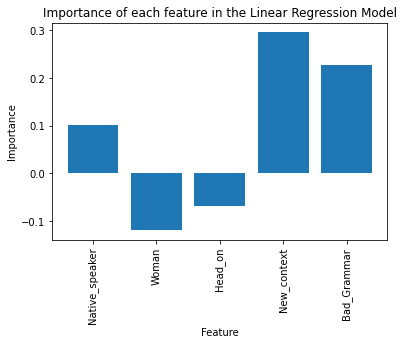

In [ ]:
importance = model.coef_

# Create a bar chart of the importance of each feature
plt.bar(range(X_train.shape[1]), importance)
plt.xticks(range(X_train.shape[1]), training_data[feature_names], rotation=90)
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.title("Importance of each feature in the Linear Regression Model")

# Show the plot
plt.show()

Accuracy of the model: 0.29411030560157503


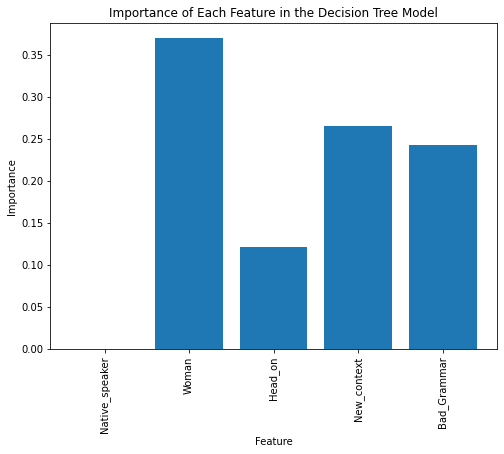

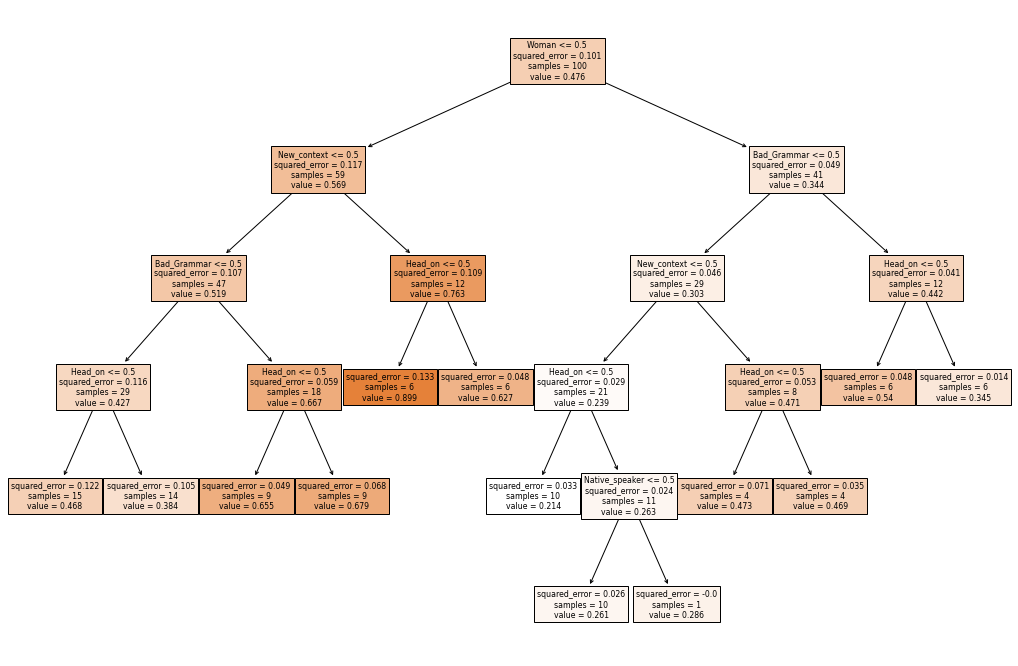

In [ ]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

# Create a decision tree model
model2 = DecisionTreeRegressor()

# Fit the model to the data
model2.fit(X_train, y_train)

# Get the importance of each feature
importance = model2.feature_importances_

# Create a bar chart of the importance of each feature
plt.figure(figsize=(8, 6))
plt.bar(range(X_train.shape[1]), importance)
plt.xticks(range(X_train.shape[1]), training_data[feature_names], rotation=90)
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.title("Importance of Each Feature in the Decision Tree Model")

# Print the accuracy of the model
print("Accuracy of the model:", model.score(X_train, y_train))


# Plot the decision tree
plt.figure(figsize=(18, 12))
plot_tree(model2, filled=True, feature_names=feature_names)
plt.show()

# Observations

In this section we list the observations made from the model evaluation.

From the graph, we can make the following observations:
* The model performed surprisingly well, despite the errors
  - WER was 48.1% and benchmarks are typically 20-30%
  - We were able to decipher the context in most cases
* The model was slow to interpret given the high resolution of videos (typically 1-2.5 minutes using a GPU)
  - Becomes difficult / impractical for real-time transcription
* When the speaker is a non-native speaker, the model produces worse results
  - There is a perceived bias against non-native speakers
* Angle of taking the video wasn't significant to the model performance
* Gender of the speaker did make a small difference with the model performing better for women speakers
* Sentences with newer context and / or bad grammar got worse results

# Suggestions for Improvements:
The bias perceived in the model can be improved by training the model with the following:
- non-native English speakers
- using sythetically generated sentences vs video clips taken fropm other existing videos